Importing the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting The MFCC Features from the Audio Files

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import soundfile as sf
import librosa
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras

# Set the path to the folder containing the audio files
data_folder = 'Path of the folder containing the audio files'

# Set the desired number of MFCC coefficients and maximum sequence length
num_coefficients = 10
max_sequence_length = 1000

# Create empty lists to store the MFCC features and speaker labels
mfcc_features = []
speaker_labels = []

# Iterate through the audio files in the folder
for filename in os.listdir(data_folder):
    # The format of the audio file should be speakerID-index.flac
    if filename.endswith('.flac'):
        # Extract the speaker ID from the filename
        speaker_id = filename.split('-')[0]

        # Load the audio file
        audio, sr = sf.read(os.path.join(data_folder, filename))

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_coefficients)

        # Pad or truncate the MFCC features to the maximum sequence length
        if mfcc.shape[1] < max_sequence_length:
            pad_width = max_sequence_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
        else:
            mfcc = mfcc[:, :max_sequence_length]

        # Append the MFCC features and speaker label to the lists
        mfcc_features.append(mfcc)
        speaker_labels.append(speaker_id)

# Convert the lists to numpy arrays
mfcc_features = np.array(mfcc_features)
speaker_labels = np.array(speaker_labels)

# Split the data into training and testing sets
trainMFCC, testMFCC, trainSpeakerIDs, testSpeakerIDs = train_test_split(
    mfcc_features, speaker_labels, test_size=0.2, random_state=42)

# Reshape the input data
trainMFCC = np.reshape(trainMFCC, (*trainMFCC.shape[:2], -1))
testMFCC = np.reshape(testMFCC, (*testMFCC.shape[:2], -1))

# Convert speaker IDs to numerical labels
unique_speakers = np.unique(speaker_labels)
num_speakers = len(unique_speakers)
label_to_id = {label: i for i, label in enumerate(unique_speakers)}
trainLabels = np.array([label_to_id[label] for label in trainSpeakerIDs])
testLabels = np.array([label_to_id[label] for label in testSpeakerIDs])



Applying Scaling and LSTM model to the extracted features

In [ ]:
from sklearn.preprocessing import StandardScaler
# Apply StandardScaler to the training and test data
scaler = StandardScaler()
trainMFCC_scaled = scaler.fit_transform(trainMFCC.reshape(-1, trainMFCC.shape[-1])).reshape(trainMFCC.shape)
testMFCC_scaled = scaler.transform(testMFCC.reshape(-1, testMFCC.shape[-1])).reshape(testMFCC.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=trainMFCC_scaled.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))

model.add(Dense(num_speakers, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# Train the model
model.fit(trainMFCC_scaled, trainLabels, validation_data=(testMFCC_scaled, testLabels), epochs=50, batch_size=32)

# Evaluate the model
_, accuracy = model.evaluate(testMFCC_scaled, testLabels)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/50
62/62 [==============================] - 20s 229ms/step - loss: 3.0579 - accuracy: 0.0701 - val_loss: 2.8206 - val_accuracy: 0.1046
Epoch 2/50
62/62 [==============================] - 12s 192ms/step - loss: 2.6528 - accuracy: 0.1124 - val_loss: 2.4767 - val_accuracy: 0.1207
Epoch 3/50
62/62 [==============================] - 11s 181ms/step - loss: 2.3668 - accuracy: 0.2087 - val_loss: 2.1139 - val_accuracy: 0.2394
Epoch 4/50
62/62 [==============================] - 13s 204ms/step - loss: 1.9135 - accuracy: 0.3463 - val_loss: 1.6663 - val_accuracy: 0.5050
Epoch 5/50
62/62 [==============================] - 13s 206ms/step - loss: 1.4647 - accuracy: 0.5101 - val_loss: 1.1264 - val_accuracy: 0.6258
Epoch 6/50
62/62 [==============================] - 13s 207ms/step - loss: 1.0920 - accuracy: 0.6411 - val_loss: 0.6640 - val_accuracy: 0.7847
Epoch 7/50
62/62 [==============================] - 12s 202ms/step - loss: 0.7819 - accuracy: 0.7520 - val_loss: 0.7950 - val_accuracy: 0.7384

Confusion Matrix and Classifcation Report

16/16 [==============================] - 3s 51ms/step


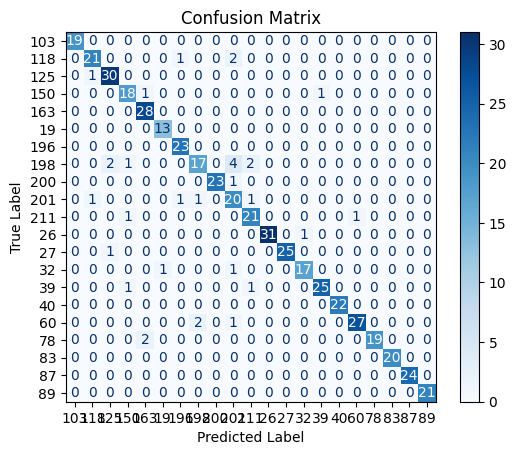

              precision    recall  f1-score   support

         103       1.00      1.00      1.00        19
         118       0.91      0.88      0.89        24
         125       0.91      0.97      0.94        31
         150       0.86      0.90      0.88        20
         163       0.90      1.00      0.95        28
          19       0.93      1.00      0.96        13
         196       0.92      1.00      0.96        23
         198       0.85      0.65      0.74        26
         200       1.00      0.96      0.98        24
         201       0.69      0.83      0.75        24
         211       0.84      0.91      0.87        23
          26       1.00      0.97      0.98        32
          27       1.00      0.96      0.98        26
          32       0.94      0.89      0.92        19
          39       0.96      0.93      0.94        27
          40       1.00      1.00      1.00        22
          60       0.96      0.90      0.93        30
          78       1.00    

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

predictions = model.predict(testMFCC_scaled)
predicted_labels = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(testLabels, predicted_labels)

# Plot the confusion matrix
labels = unique_speakers
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report = classification_report(testLabels, predicted_labels, target_names=unique_speakers)
print(report)

Applying Robust Scaling instead of Standard Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler

# Apply RobustScaler to the training and test data
scaler = RobustScaler()
trainMFCC_scaled = scaler.fit_transform(trainMFCC.reshape(-1, trainMFCC.shape[-1])).reshape(trainMFCC.shape)
testMFCC_scaled = scaler.transform(testMFCC.reshape(-1, testMFCC.shape[-1])).reshape(testMFCC.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=trainMFCC_scaled.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(num_speakers, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# Train the model
model.fit(trainMFCC_scaled, trainLabels, validation_data=(testMFCC_scaled, testLabels), epochs=50, batch_size=32)

# Evaluate the model
_, accuracy = model.evaluate(testMFCC_scaled, testLabels)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/50
62/62 [==============================] - 15s 161ms/step - loss: 2.5370 - accuracy: 0.1840 - val_loss: 1.8569 - val_accuracy: 0.3722
Epoch 2/50
62/62 [==============================] - 6s 102ms/step - loss: 1.5436 - accuracy: 0.4864 - val_loss: 1.3658 - val_accuracy: 0.5533
Epoch 3/50
62/62 [==============================] - 9s 139ms/step - loss: 1.0177 - accuracy: 0.6623 - val_loss: 0.9271 - val_accuracy: 0.6861
Epoch 4/50
62/62 [==============================] - 6s 102ms/step - loss: 0.8085 - accuracy: 0.7298 - val_loss: 0.8443 - val_accuracy: 0.7203
Epoch 5/50
62/62 [==============================] - 7s 114ms/step - loss: 0.7006 - accuracy: 0.7681 - val_loss: 0.6549 - val_accuracy: 0.7948
Epoch 6/50
62/62 [==============================] - 6s 97ms/step - loss: 0.5882 - accuracy: 0.8100 - val_loss: 0.7628 - val_accuracy: 0.7445
Epoch 7/50
62/62 [==============================] - 7s 120ms/step - loss: 0.5046 - accuracy: 0.8458 - val_loss: 0.7274 - val_accuracy: 0.7646
Epoch 

Tuning The LSTM Model with Standard Scaler

In [ ]:
from sklearn.preprocessing import StandardScaler
# Apply StandardScaler to the training and test data
scaler = StandardScaler()
trainMFCC_scaled = scaler.fit_transform(trainMFCC.reshape(-1, trainMFCC.shape[-1])).reshape(trainMFCC.shape)
testMFCC_scaled = scaler.transform(testMFCC.reshape(-1, testMFCC.shape[-1])).reshape(testMFCC.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=trainMFCC_scaled.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256))
model.add(Dropout(0.2))

model.add(Dense(num_speakers, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(trainMFCC_scaled, trainLabels, validation_data=(testMFCC_scaled, testLabels), epochs=50, batch_size=32)

# Evaluate the model
_, accuracy = model.evaluate(testMFCC_scaled, testLabels)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/50
62/62 [==============================] - 40s 444ms/step - loss: 2.5547 - accuracy: 0.1845 - val_loss: 1.7712 - val_accuracy: 0.4406
Epoch 2/50
62/62 [==============================] - 15s 247ms/step - loss: 1.7423 - accuracy: 0.4103 - val_loss: 1.6292 - val_accuracy: 0.4507
Epoch 3/50
62/62 [==============================] - 15s 250ms/step - loss: 1.2573 - accuracy: 0.5691 - val_loss: 1.0856 - val_accuracy: 0.6600
Epoch 4/50
62/62 [==============================] - 25s 401ms/step - loss: 0.9648 - accuracy: 0.6668 - val_loss: 0.8074 - val_accuracy: 0.7264
Epoch 5/50
62/62 [==============================] - 16s 257ms/step - loss: 0.6810 - accuracy: 0.7712 - val_loss: 0.7097 - val_accuracy: 0.7746
Epoch 6/50
62/62 [==============================] - 23s 368ms/step - loss: 0.5751 - accuracy: 0.8039 - val_loss: 0.7079 - val_accuracy: 0.7807
Epoch 7/50
62/62 [==============================] - 19s 309ms/step - loss: 0.4842 - accuracy: 0.8432 - val_loss: 0.6383 - val_accuracy: 0.7746

Classifcation Report and Confusion Matrix for the Tuned Model

16/16 [==============================] - 2s 57ms/step


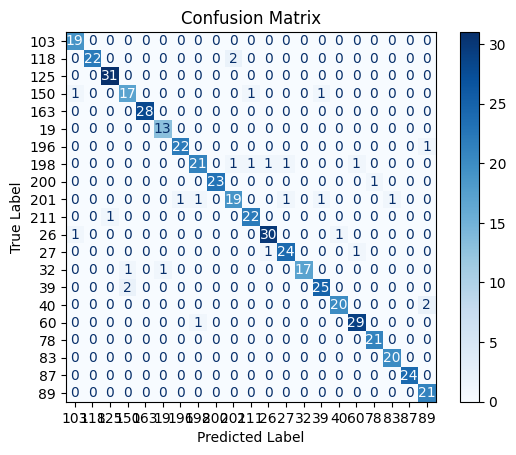

              precision    recall  f1-score   support

         103       0.90      1.00      0.95        19
         118       1.00      0.92      0.96        24
         125       0.97      1.00      0.98        31
         150       0.85      0.85      0.85        20
         163       1.00      1.00      1.00        28
          19       0.93      1.00      0.96        13
         196       0.96      0.96      0.96        23
         198       0.91      0.81      0.86        26
         200       1.00      0.96      0.98        24
         201       0.86      0.79      0.83        24
         211       0.92      0.96      0.94        23
          26       0.94      0.94      0.94        32
          27       0.92      0.92      0.92        26
          32       1.00      0.89      0.94        19
          39       0.93      0.93      0.93        27
          40       0.95      0.91      0.93        22
          60       0.94      0.97      0.95        30
          78       0.95    

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

predictions = model.predict(testMFCC_scaled)
predicted_labels = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(testLabels, predicted_labels)

# Plot the confusion matrix
labels = unique_speakers
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report = classification_report(testLabels, predicted_labels, target_names=unique_speakers)
print(report)

After Finetuning the LSTM model little further

In [ ]:
from sklearn.preprocessing import StandardScaler
# Apply StandardScaler to the training and test data
scaler = StandardScaler()
trainMFCC_scaled = scaler.fit_transform(trainMFCC.reshape(-1, trainMFCC.shape[-1])).reshape(trainMFCC.shape)
testMFCC_scaled = scaler.transform(testMFCC.reshape(-1, testMFCC.shape[-1])).reshape(testMFCC.shape)

# Define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=trainMFCC_scaled.shape[1:], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256))
model.add(Dropout(0.2))

model.add(Dense(num_speakers, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(trainMFCC_scaled, trainLabels, validation_data=(testMFCC_scaled, testLabels), epochs=70, batch_size=32)

# Evaluate the model
_, accuracy = model.evaluate(testMFCC_scaled, testLabels)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/70
62/62 [==============================] - 23s 231ms/step - loss: 2.6342 - accuracy: 0.1628 - val_loss: 2.1144 - val_accuracy: 0.3199
Epoch 2/70
62/62 [==============================] - 13s 203ms/step - loss: 1.8342 - accuracy: 0.3836 - val_loss: 1.3342 - val_accuracy: 0.5513
Epoch 3/70
62/62 [==============================] - 13s 203ms/step - loss: 1.3496 - accuracy: 0.5272 - val_loss: 1.0711 - val_accuracy: 0.6559
Epoch 4/70
62/62 [==============================] - 12s 198ms/step - loss: 0.9331 - accuracy: 0.6905 - val_loss: 0.8974 - val_accuracy: 0.7062
Epoch 5/70
62/62 [==============================] - 12s 197ms/step - loss: 0.6545 - accuracy: 0.7807 - val_loss: 0.6817 - val_accuracy: 0.7626
Epoch 6/70
62/62 [==============================] - 13s 214ms/step - loss: 0.5040 - accuracy: 0.8372 - val_loss: 0.5894 - val_accuracy: 0.8149
Epoch 7/70
62/62 [==============================] - 14s 233ms/step - loss: 0.4241 - accuracy: 0.8584 - val_loss: 0.4561 - val_accuracy: 0.8551

Classification Report and Confusion Matrix

16/16 [==============================] - 1s 81ms/step


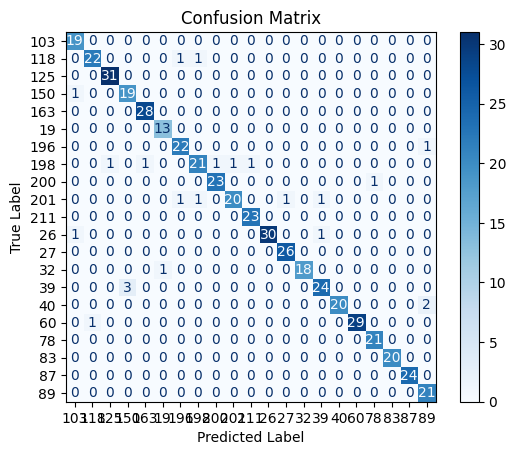

              precision    recall  f1-score   support

         103       0.90      1.00      0.95        19
         118       0.96      0.92      0.94        24
         125       0.97      1.00      0.98        31
         150       0.86      0.95      0.90        20
         163       0.97      1.00      0.98        28
          19       0.93      1.00      0.96        13
         196       0.92      0.96      0.94        23
         198       0.91      0.81      0.86        26
         200       0.96      0.96      0.96        24
         201       0.95      0.83      0.89        24
         211       0.96      1.00      0.98        23
          26       1.00      0.94      0.97        32
          27       0.96      1.00      0.98        26
          32       1.00      0.95      0.97        19
          39       0.92      0.89      0.91        27
          40       1.00      0.91      0.95        22
          60       1.00      0.97      0.98        30
          78       0.95    

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

predictions = model.predict(testMFCC_scaled)
predicted_labels = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(testLabels, predicted_labels)

# Plot the confusion matrix
labels = unique_speakers
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

report = classification_report(testLabels, predicted_labels, target_names=unique_speakers)
print(report)